Import the libraries

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import joblib
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

This cell imports the cleaned data from a CSV file into a DataFrame.


In [38]:
df = pd.read_csv("../datos/cleandata.csv")
df

,warranty,condition,seller_contact,base_price,non_mercado_pago_payment_methods,variations,price,buying_mode,tags,accepts_mercadopago,...,available_quantity,seller_address_longitude,seller_address_latitude,shipping_local_pick_up,shipping_free_shipping,shipping_mode,pixeles,pixeles_max,days_active,days_since_last_update
0,False,new,False,80.00,3,False,80.00,buy_it_now,True,True,...,1,-58.398671,-34.628070,True,False,not_specified,187500.0,1080000.0,60,0
1,True,used,False,2650.00,2,False,2650.00,buy_it_now,False,True,...,1,-58.505917,-34.593552,True,False,me2,166666.0,605787.0,60,0
2,False,used,False,60.00,3,False,60.00,buy_it_now,True,True,...,1,-58.414395,-34.623391,True,False,me2,187500.0,1080000.0,60,0
3,False,new,False,580.00,3,False,580.00,buy_it_now,False,True,...,1,-58.492921,-34.628189,True,False,me2,186543.0,186543.0,66,6
4,True,used,False,30.00,3,False,30.00,buy_it_now,True,True,...,1,-58.549504,-34.634655,True,False,not_specified,187500.0,307200.0,60,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94242,True,new,False,417.99,2,False,417.99,buy_it_now,True,True,...,2,-58.368735,-34.661085,True,False,me2,193500.0,1117200.0,60,0
94243,False,used,False,30.00,2,False,30.00,buy_it_now,True,True,...,1,-58.614289,-34.489321,True,False,me2,187500.0,1080000.0,60,0
94244,False,new,False,239.00,2,False,239.00,buy_it_now,False,True,...,5,-58.678214,-34.369864,False,False,not_specified,187500.0,1080000.0,60,0
94245,False,used,False,600.00,0,True,600.00,buy_it_now,False,True,...,1,-58.624120,-34.646786,False,False,me2,187500.0,1080000.0,60,0


This provides a summary of the DataFrame `df`, including the number of entries, column names, data types, and memory usage.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94247 entries, 0 to 94246
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   warranty                          94247 non-null  bool   
 1   condition                         94247 non-null  object 
 2   seller_contact                    94247 non-null  bool   
 3   base_price                        94247 non-null  float64
 4   non_mercado_pago_payment_methods  94247 non-null  int64  
 5   variations                        94247 non-null  bool   
 6   price                             94247 non-null  float64
 7   buying_mode                       94247 non-null  object 
 8   tags                              94247 non-null  bool   
 9   accepts_mercadopago               94247 non-null  bool   
 10  original_price                    94247 non-null  float64
 11  automatic_relist                  94247 non-null  bool   
 12  stat

Let's count the occurrences of each condition in the `condition` column and visualize the distribution.

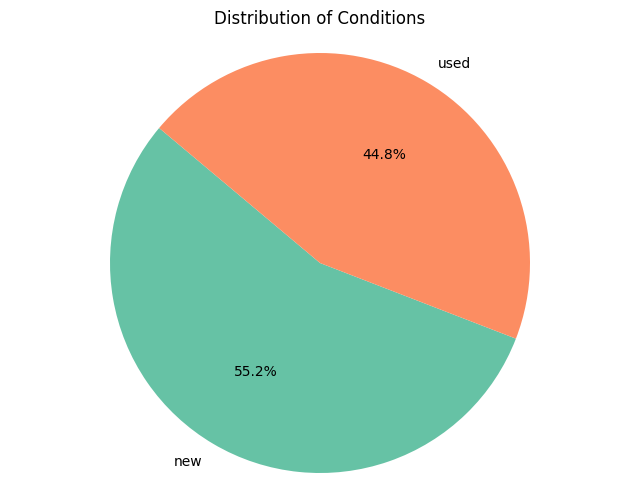

In [43]:
condition_counts = df['condition'].value_counts()
colors = sns.color_palette('Set2')[0:len(condition_counts)]

plt.figure(figsize=(8, 6))
plt.pie(condition_counts, labels=condition_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribution of Conditions')
plt.axis('equal')
plt.show()

This code maps the categorical values in the `condition` column to numeric values for easier analysis. 'used' is converted to 0, and 'new' is converted to 1.

In [5]:
df['condition'] = df['condition'].map({'used': 0, 'new': 1})

Let's separate the features from the target variable. We create `X` by dropping the `condition` column, which leaves us with the features we’ll use for modeling. The target variable `y` will just be the `condition` column.

In [6]:
X = df.drop('condition', axis=1)  # Features
y = df['condition'] #Target

Split the data into training and testing sets. We use `train_test_split` to create `X_train` and `y_train` for training, and `X_test` and `y_test` for testing. We set aside 30% of the data for testing and use a `random_state` of 42 for reproducibility.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Identify the numeric and categorical columns in our features. We use `select_dtypes` to get lists of numeric (`num_cols`) and categorical (`cat_cols`) columns.

In [8]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category', 'string', 'boolean']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),  
        ('cat', OneHotEncoder(), cat_cols)   
    ]
)

Let’s create a dictionary of different machine learning models that we can use for classification. Each model is associated with its name for easy reference. 

In [9]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree Classifier': DecisionTreeClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Naive Bayes': GaussianNB(),
    'XGB Classifier': XGBClassifier()
}

This function will train each model, make predictions, and calculate accuracy. It also saves the best-performing model.

In [10]:
def evaluate_models(X_train, y_train, X_test, y_test, models):
    results = {}
    best_model_name = None
    best_accuracy = 0
    best_pipeline = None

    for model_name, model in models.items():
        pipeline = Pipeline(steps=[  # Define the pipeline within the loop
            ('preprocessor', preprocessor),
            ('classifier', model)  # Use the current model
        ])
        
        pipeline.fit(X_train, y_train)  # Fit the model to the training set
        
        y_pred = pipeline.predict(X_test)  # Predictions on the test set
        
        accuracy = accuracy_score(y_test, y_pred)
        results[model_name] = accuracy
        
        print(f"{model_name} Accuracy: {accuracy:.2f}")
        print(classification_report(y_test, y_pred))
        
        # Check for the best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_name = model_name
            best_pipeline = pipeline

    # Save the best model
    if best_pipeline is not None:
        joblib.dump(best_pipeline, f'../datos/best_model_{best_model_name}.pkl')
        print(f"Best model saved as: ../datos/best_model_{best_model_name}.pkl")

    return results

Now, let's run our model evaluation function to train and assess all the models we defined earlier. We pass in the training and testing data along with our models.

In [11]:
results = evaluate_models(X_train, y_train, X_test, y_test, models)
results

Logistic Regression Accuracy: 0.72
              precision    recall  f1-score   support

           0       0.67      0.72      0.69     12674
           1       0.76      0.72      0.74     15601

    accuracy                           0.72     28275
   macro avg       0.71      0.72      0.72     28275
weighted avg       0.72      0.72      0.72     28275

Random Forest Accuracy: 0.83
              precision    recall  f1-score   support

           0       0.78      0.86      0.82     12674
           1       0.87      0.81      0.84     15601

    accuracy                           0.83     28275
   macro avg       0.83      0.83      0.83     28275
weighted avg       0.83      0.83      0.83     28275

Decision Tree Classifier Accuracy: 0.77
              precision    recall  f1-score   support

           0       0.74      0.75      0.74     12674
           1       0.79      0.79      0.79     15601

    accuracy                           0.77     28275
   macro avg       0.77 

{'Logistic Regression': 0.7167462422634836,
 'Random Forest': 0.8287886825817861,
 'Decision Tree Classifier': 0.7684173297966401,
 'K-Nearest Neighbors': 0.7387798408488063,
 'Gradient Boosting': 0.8149602122015915,
 'Naive Bayes': 0.5824933687002652,
 'XGB Classifier': 0.8370291777188329}

Here, we’re loading the best model that we saved earlier. We specify the path to the XGB Classifier model file.

In [13]:
best_model_path = f'../datos/best_model_XGB Classifier.pkl'
best_pipeline = joblib.load(best_model_path)

We extract the feature importances to see which features contribute the most to the model’s predictions.

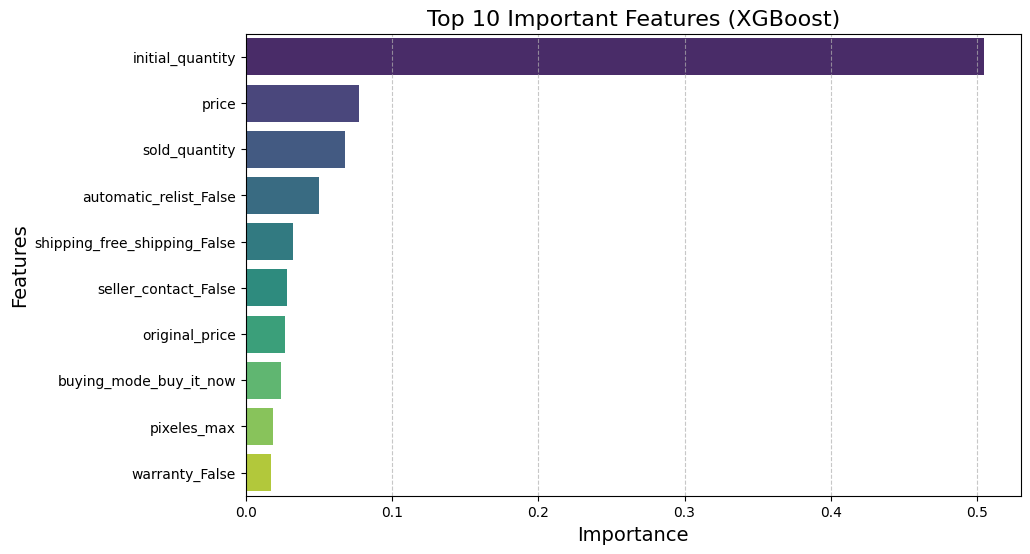

In [41]:

importances = best_pipeline.named_steps['classifier'].feature_importances_
feature_names = num_cols + list(best_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(cat_cols))

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette='viridis', hue='Feature', dodge=False)
plt.title('Top 10 Important Features (XGBoost)', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

- The feature that contributes the most to the model is **'initial_quantity'** with an importance of approximately **0.5.**. It indicates that this feature has a significant weight in the decisions made by the model. Generally, the higher the importance of a feature, the more influential it is on the model's performance. This suggests that changes in 'initial_quantity' can have a notable impact on the predictions made by the model."

A confusion matrix is a table used to evaluate the performance of a classification model. It shows the number of correct and incorrect predictions, broken down by class. 

- **True Positives (TP)**: Correctly predicted positive cases.
- **True Negatives (TN)**: Correctly predicted negative cases.
- **False Positives (FP)**: Incorrectly predicted positive cases (also known as Type I errors).
- **False Negatives (FN)**: Incorrectly predicted negative cases (Type II errors).

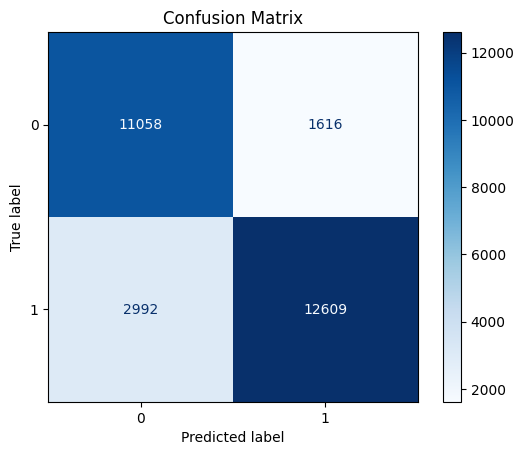

In [30]:
y_pred = best_pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_pipeline.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

- **True Negatives (TN)**: 11058 (true label 0, predicted label 0)  
  Correctly classified as 0.

- **False Negatives (FN)**: 2992 (true label 1, predicted label 0)  
  Incorrectly classified as 0 when they are actually 1.

- **True Positives (TP)**: 12609 (true label 1, predicted label 1)  
  Correctly classified as 1.

- **False Positives (FP)**: 1616 (true label 0, predicted label 1)  
  Incorrectly classified as 1 when they are actually 0.

The ROC (Receiver Operating Characteristic) curve is a graphical representation used to assess the performance of a binary classification model. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings.

- **True Positive Rate (TPR)**: Also known as sensitivity, it measures the proportion of actual positives correctly identified by the model.
- **False Positive Rate (FPR)**: It measures the proportion of actual negatives incorrectly identified as positives.

The ROC curve helps visualize the trade-offs between sensitivity and specificity. A model that perfectly classifies all instances would reach the top-left corner of the plot, where TPR is 1 and FPR is 0. The area under the curve (AUC) quantifies the overall ability of the model to discriminate between the positive and negative classes—higher values indicate better performance.

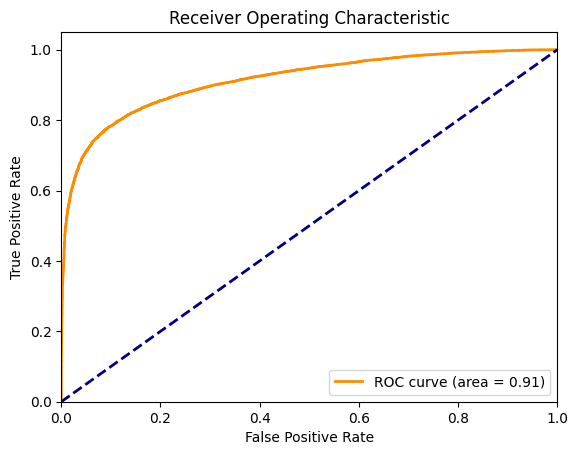

In [31]:
from sklearn.metrics import roc_curve, auc

y_prob = best_pipeline.predict_proba(X_test)[:, 1]  
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

- An AUC of 0.91 means that the model has a 91% probability of correctly classifying a positive instance versus a negative one. It is an indicator that this model performs well in classification.
